# 📊 Visualização da Simulação SAC

Este notebook apresenta a visualização gráfica de um financiamento simulado pelo sistema de amortização constante (SAC). Serão exibidos gráficos relacionados ao saldo devedor, à composição das parcelas e ao valor total pago mês a mês.

## 🔧 Configuração do Ambiente

Nesta célula, são importadas as bibliotecas necessárias e configurado o caminho para acesso ao código-fonte localizado na pasta `src/`.

In [1]:
# 📦 Imports necessários e configuração do path para src/
import os, sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Garante que a pasta src/ esteja no sys.path (assumindo estrutura SAD-FI/)
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Imports do projeto (arquitetura em camadas)
from domain.financiamento import Financiamento
from domain.simulador_sac import SimuladorSAC
# from domain.simulador_sac_ipca import SimuladorSAC_IPCA  # use quando for comparar IPCA


## 💰 Criação do Financiamento e Execução da Simulação

Simularemos um financiamento no valor total de R$ 100.000, com entrada de R$ 20.000, prazo de 12 meses e taxa de juros anual de 12%. A simulação retorna `SimulacaoResultado`.


In [4]:
# 💰 Criar um financiamento de exemplo e executar a simulação (SAC fixo)
financiamento = Financiamento(
    valor_total=100_000.0,
    entrada=20_000.0,
    prazo_anos=1,
    sistema='SAC',
    taxa_juros_anual=0.12,  # 12% ao ano
)

# 🧠 Simular com taxa de juros de 12% ao ano
simulador = SimuladorSAC(financiamento, taxa_juros_anual=0.12)

# ⚠️ Agora o retorno é um SimulacaoResultado (não é lista de parcelas)
resultado = simulador.simular()

# Assert mínimo (TDD): 12 parcelas e totais positivos
assert len(resultado.parcelas) == 12
assert resultado.total_pago > 0 and resultado.total_juros > 0

print("Resumo:", resultado)
print("Dict:", resultado.to_dict_resumo())


Resumo: SimulacaoResultado(parcelas=12, total_pago=84934.17, total_juros=4934.17)
Dict: {'parcelas': 12, 'total_pago': 84934.17232598319, 'total_juros': 4934.172325983183}


## 📋 Conversão dos Dados para Tabela

Para facilitar a manipulação e visualização, as parcelas simuladas são convertidas para um `DataFrame` do pandas.

In [5]:
# 📋 Converter para DataFrame a partir de resultado.parcelas
dados = [{
    "Parcela": p.numero,
    "Amortização": p.amortizacao,
    "Juros": p.juros,
    "Valor Total": p.valor_total,
    "Saldo Devedor (antes)": p.saldo_devedor
} for p in resultado.parcelas]

df = pd.DataFrame(dados)

# Assert mínimo (TDD): colunas e tamanho esperados
cols_esperadas = {"Parcela","Amortização","Juros","Valor Total","Saldo Devedor (antes)"}
assert cols_esperadas.issubset(set(df.columns))
assert len(df) == 12

df.head()

,Parcela,Amortização,Juros,Valor Total,Saldo Devedor (antes)
0,1,6666.666667,759.103435,7425.770101,73333.333333
1,2,6666.666667,695.844815,7362.511482,66666.666667
2,3,6666.666667,632.586196,7299.252862,60000.000000
3,4,6666.666667,569.327576,7235.994243,53333.333333
4,5,6666.666667,506.068957,7172.735623,46666.666667


## 📉 Evolução do Saldo Devedor

Gráfico que mostra como o saldo devedor é reduzido ao longo do tempo. No SAC, ele reduz de forma linear devido à amortização constante.


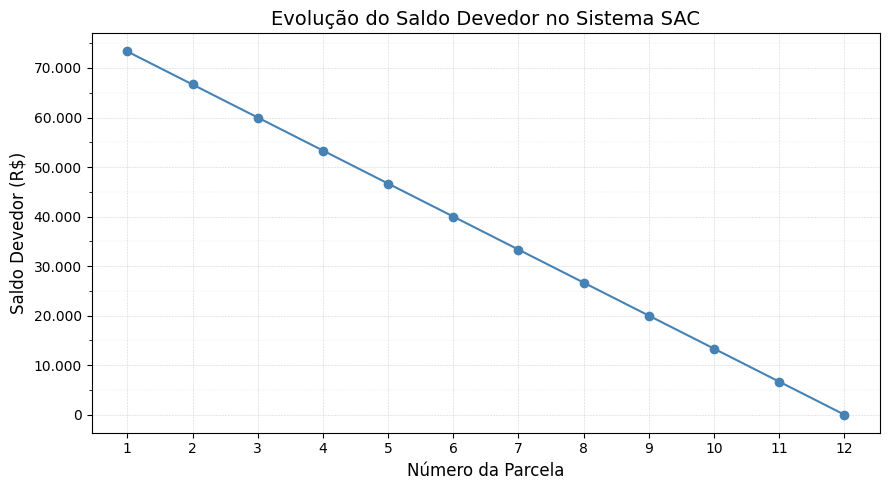

In [6]:
import matplotlib.ticker as ticker

plt.figure(figsize=(9, 5))

# Plot da linha
plt.plot(df['Parcela'], df['Saldo Devedor (antes)'], marker='o', color='steelblue')

# Título e rótulos
plt.title('Evolução do Saldo Devedor no Sistema SAC', fontsize=14)
plt.xlabel('Número da Parcela', fontsize=12)
plt.ylabel('Saldo Devedor (R$)', fontsize=12)

# Formatação de milhar com ponto (estilo brasileiro)
def formatar_reais(valor, pos):
    return f'{int(round(valor)):,}'.replace(',', '.')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_reais))

# Marcas no eixo Y (múltiplos de 10.000) e menores (a cada 5.000)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(10000))
plt.gca().yaxis.set_minor_locator(ticker.MultipleLocator(5000))

# Todas as parcelas no eixo X
plt.xticks(df['Parcela'])

# Grades mais claras e finas
plt.grid(which='major', linestyle='--', linewidth=0.4, color='lightgray')
plt.grid(which='minor', linestyle=':', linewidth=0.3, color='lightgray')

plt.tight_layout()
plt.show()


## 📊 Composição da Parcela: Juros x Amortização

Neste gráfico, visualizamos como a parcela mensal é composta por duas partes: os juros (que decrescem com o tempo) e a amortização (que permanece constante).

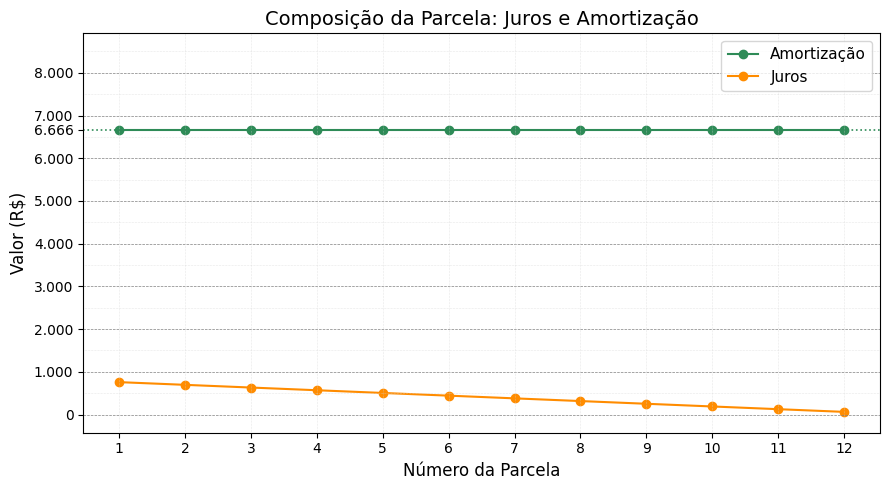

In [7]:
# 📊 Gráfico 2 – Juros vs Amortização
import matplotlib.ticker as ticker

# ✅ Verifica se as colunas necessárias estão no DataFrame
colunas_necessarias = {'Parcela', 'Amortização', 'Juros'}
if not colunas_necessarias.issubset(df.columns):
    raise ValueError(f"Colunas esperadas não encontradas no DataFrame. Colunas atuais: {df.columns.tolist()}")

plt.figure(figsize=(9, 5))

# Valor da amortização (constante)
valor_amortizacao = df['Amortização'].iloc[0]

# Determina limite superior do eixo Y
y_max = df[['Amortização', 'Juros']].values.max()
y_ticks_visiveis = list(range(0, int(y_max) + 2000, 1000))  # apenas os que terminam em 000

# Garante que a amortização apareça como tick visível
if int(valor_amortizacao) not in y_ticks_visiveis:
    y_ticks_visiveis.append(int(valor_amortizacao))
    y_ticks_visiveis = sorted(y_ticks_visiveis)

# Gera todos os ticks (500 em 500), mas só exibe os desejados
y_ticks_todos = list(range(0, int(y_max) + 2000, 500))
plt.yticks(y_ticks_visiveis)

# Formatador de milhar com ponto
def formatar_milhar(valor, pos):
    return f'{int(valor):,}'.replace(',', '.')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_milhar))

# Plot das curvas
plt.plot(df['Parcela'], df['Amortização'], label='Amortização', marker='o', color='seagreen')
plt.plot(df['Parcela'], df['Juros'], label='Juros', marker='o', color='darkorange')

# Título e rótulos
plt.title('Composição da Parcela: Juros e Amortização', fontsize=14)
plt.xlabel('Número da Parcela', fontsize=12)
plt.ylabel('Valor (R$)', fontsize=12)
plt.xticks(df['Parcela'])

# Grades horizontais: todas as de 500, mas só os rótulos de 1000 + amortização
for y in y_ticks_todos:
    if y % 1000 == 0:
        plt.axhline(y, linestyle='--', linewidth=0.5, color='gray')
    elif y % 500 == 0:
        plt.axhline(y, linestyle=':', linewidth=0.4, color='lightgray')

# Grade vertical para cada parcela
for x in df['Parcela']:
    plt.axvline(x, linestyle=':', linewidth=0.4, color='lightgray')

# Linha pontilhada destacando amortização
plt.axhline(valor_amortizacao, linestyle=':', linewidth=1.2, color='seagreen')

# Legenda
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()






## 💸 Valor Total da Parcela ao Longo do Tempo

Este gráfico mostra o valor total pago em cada parcela, que diminui ao longo do tempo no sistema SAC devido à redução dos juros.

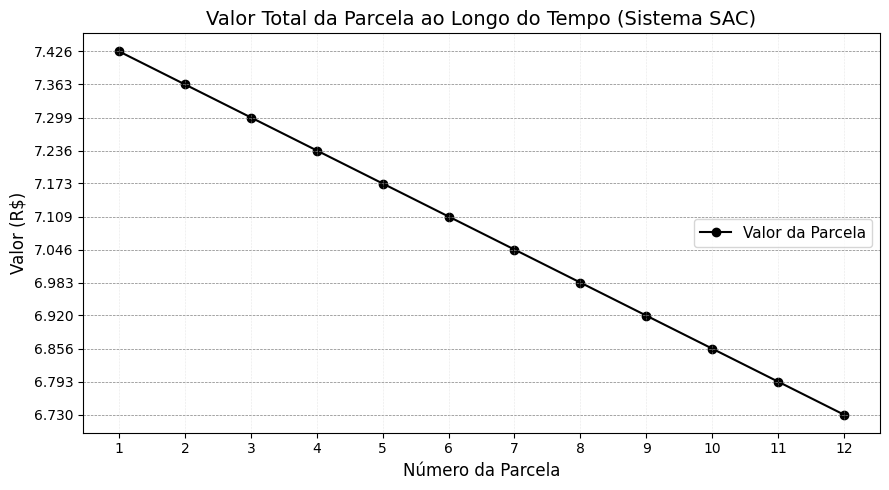

In [8]:
# 💸 Gráfico 3 – Valor Total da Parcela
import matplotlib.ticker as ticker

# ✅ Verifica se as colunas necessárias estão presentes
colunas_necessarias = {'Parcela', 'Valor Total'}
if not colunas_necessarias.issubset(df.columns):
    raise ValueError(f"Colunas esperadas não encontradas no DataFrame. Colunas atuais: {df.columns.tolist()}")

plt.figure(figsize=(9, 5))

# Extrai todos os valores distintos das parcelas (ordenados do maior para o menor)
valores_y = sorted(df['Valor Total'].unique(), reverse=True)
valores_y_int = [int(round(v)) for v in valores_y]

# Define os rótulos exatos no eixo Y
plt.yticks(valores_y_int)

# Formatador de milhar com ponto
def formatar_milhar(valor, pos):
    return f'{int(valor):,}'.replace(',', '.')

plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(formatar_milhar))

# Plot do gráfico
plt.plot(df['Parcela'], df['Valor Total'], color='black', marker='o', label='Valor da Parcela')

# Título e rótulos
plt.title('Valor Total da Parcela ao Longo do Tempo (Sistema SAC)', fontsize=14)
plt.xlabel('Número da Parcela', fontsize=12)
plt.ylabel('Valor (R$)', fontsize=12)
plt.xticks(df['Parcela'])

# Grades horizontais para cada valor da parcela
for y in valores_y_int:
    plt.axhline(y, linestyle='--', linewidth=0.5, color='gray')

# Grade vertical para cada parcela
for x in df['Parcela']:
    plt.axvline(x, linestyle=':', linewidth=0.4, color='lightgray')

# Legenda (opcional)
plt.legend(fontsize=11)

plt.tight_layout()
plt.show()




## ✅ Conclusão

A simulação confirma o comportamento esperado do sistema SAC. Os gráficos evidenciam a amortização constante, a queda dos juros e a consequente redução do valor total das parcelas ao longo do tempo.

---
# Fim da Sprint 1.
---
---

---
---
# O conteúdo a partir daqui veio da Sprint 2


## Calcular e exibir custo total de cada modalidade

Nesta etapa, implementa-se a função `exibir_comparacao_custos()`, que recebe dois objetos `SimulacaoResultado` e apresenta um **gráfico de barras** com o custo total (`total_pago`) de cada modalidade simulada.

O objetivo é:
- Visualizar de forma clara a diferença entre **SAC fixo** e **SAC IPCA+**.
- Destacar a modalidade mais econômica diretamente no gráfico.
- Fornecer, no console, um **resumo numérico** com economia absoluta e relativa.

A metodologia segue a filosofia **TDD**:
1. Criar a função de visualização de forma isolada.
2. Testar a função usando dados controlados (IPCA fixo de 0,5% a.m.).
3. Garantir que os valores sejam coerentes e o gráfico seja gerado corretamente.
4. Exibir também a **mensagem de comparação** e a **recomendação final** para contextualizar o gráfico.

Na primeira célula, é definida a função `exibir_comparacao_custos()` com comentários explicativos.  
Na segunda célula, realizamos o teste prático integrando o `ControladorApp` para gerar os resultados e alimentar a visualização.


## Função de visualização

In [17]:
# --- Visualização comparativa de custos (SAC fixo vs SAC IPCA+) ---
# Mantém o padrão de comentários usado no projeto.

from matplotlib import pyplot as plt

def _fmt_brl(valor: float) -> str:
    """
    Formata número em estilo 'R$ 1.234.567,89' sem depender de locale do SO.
    """
    s = f"{valor:,.2f}"
    return "R$ " + s.replace(",", "X").replace(".", ",").replace("X", ".")

def exibir_comparacao_custos(resultado1, resultado2, nomes=("SAC fixo", "SAC IPCA+"), titulo="Comparação de custo total"):
    """
    Exibe gráfico de barras com o custo total (total_pago) de duas modalidades.

    Parâmetros:
    - resultado1, resultado2: objetos SimulacaoResultado
    - nomes (tuple[str, str]): rótulos para cada modalidade no eixo X
    - titulo (str): título do gráfico

    Saída:
    - Gráfico matplotlib exibido inline e impressão de um resumo numérico.
    """
    # Extrai os totais pagos de cada simulação
    totais = [resultado1.total_pago, resultado2.total_pago]

    # Determina qual é o menor custo para destacar na anotação
    idx_min = 0 if totais[0] <= totais[1] else 1

    # --- Plot ---
    fig, ax = plt.subplots(figsize=(6, 4))
    barras = ax.bar(range(2), totais)

    # Rótulos e título
    ax.set_title(titulo)
    ax.set_xticks([0, 1], nomes)
    ax.set_ylabel("Custo total (R$)")

    # Anota valores no topo das barras
    for i, b in enumerate(barras):
        altura = b.get_height()
        ax.text(
            b.get_x() + b.get_width()/2,
            altura,
            _fmt_brl(altura),
            ha="center",
            va="bottom"
        )

    # Anota destaque textual na barra mais barata
    ax.text(
        barras[idx_min].get_x() + barras[idx_min].get_width()/2,
        barras[idx_min].get_height()*1.02,
        "Menor custo",
        ha="center",
        va="bottom",
        fontweight="bold"
    )

    plt.tight_layout()
    plt.show()

    # --- Resumo numérico no console (útil para o relatório/prints) ---
    print("Resumo numérico:")
    print(f" - {nomes[0]}: {_fmt_brl(totais[0])}")
    print(f" - {nomes[1]}: {_fmt_brl(totais[1])}")
    economia = abs(totais[0] - totais[1])
    base = min(totais)
    perc = (economia / base * 100) if base > 0 else 0.0
    print(f" - Economia absoluta: {_fmt_brl(economia)}")
    print(f" - Economia relativa: {perc:.2f}%")


## Teste rápido (TDD) da visualização usando o ControladorApp

🔧 Iniciando teste de visualização com ControladorApp...
      data  ipca
0  01/2024   0.5
1  01/2024   0.5
2  01/2024   0.5
3  01/2024   0.5
4  01/2024   0.5
📣 Comparação: Modalidade 1 é mais vantajosa.
Economia de R$ 55,115.68 (19.13%) em relação à Modalidade 2.
💡 Recomendação: 💡 Recomendado: SAC fixo


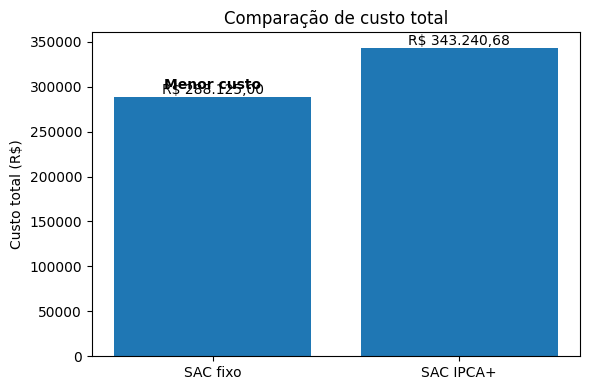

Resumo numérico:
 - SAC fixo: R$ 288.125,00
 - SAC IPCA+: R$ 343.240,68
 - Economia absoluta: R$ 55.115,68
 - Economia relativa: 19.13%
✅ Teste de visualização executado com sucesso.


In [21]:
# 🔧 Teste de visualização com ControladorApp (sem imports de presentation)
import os
from application.controlador import ControladorApp

# Caminho absoluto para o CSV do IPCA fixo
caminho_ipca_fixo = os.path.abspath(os.path.join("..", "dados", "ipca_fixo.csv"))
assert os.path.exists(caminho_ipca_fixo), f"Arquivo não encontrado: {caminho_ipca_fixo}"

# Dados para simulação SAC fixo (≈ 0,5% a.m. equivalente)
dados_sac = {
    "valor_total": 300000.0,
    "entrada": 50000.0,
    "prazo_anos": 5,
    "sistema": "SAC",
    "taxa_juros_anual": (1 + 0.005) ** 12 - 1  # ~6,17% a.a.
}

# Dados para simulação SAC IPCA+
dados_ipca = {
    "valor_total": 300000.0,
    "entrada": 50000.0,
    "prazo_anos": 5,
    "sistema": "SAC_IPCA",
    "caminho_ipca": caminho_ipca_fixo,
    "taxa_juros_anual": (1 + 0.005) ** 12 - 1   # ~6,17% a.a. (mesma base do SAC)
}

print("🔧 Iniciando teste de visualização com ControladorApp...")

# ▶️ Executa simulações
app = ControladorApp()
res_sac = app.executar_simulacao(dados_sac)
res_ipca = app.executar_simulacao(dados_ipca)

# 🧪 Asserts mínimos (TDD)
assert res_sac.total_pago > 0 and res_ipca.total_pago > 0
assert len(res_sac.parcelas) == len(res_ipca.parcelas) == 60

# 📣 Comparação + recomendação
msg = app.comparar_modalidades(res_sac, res_ipca)
recom = app.obter_recomendacao(msg)
print("📣 Comparação:", msg)
print("💡 Recomendação:", recom)

# 📊 Exibe gráfico comparativo (usa a função definida em célula anterior)
exibir_comparacao_custos(res_sac, res_ipca, nomes=("SAC fixo", "SAC IPCA+"))

print("✅ Teste de visualização executado com sucesso.")




## Implementação do Destaque Visual

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparativo_totais(totais: dict):
    """
    totais: dict {nome_modalidade: total_pago}
    Destaca a modalidade de menor custo com rótulo interno.
    Em caso de empate, não destaca nenhuma.
    """
    if not totais:
        raise ValueError("Dicionário 'totais' vazio.")

    nomes = list(totais.keys())
    valores = np.array([totais[n] for n in nomes], dtype=float)

    # Detecta melhor modalidade
    menor = valores.min()
    idx_melhor = np.where(valores == menor)[0]
    empate = len(idx_melhor) > 1

    # Cores
    cor_base = "#8fb1d1"
    cor_destaque = "#2563eb"
    cores = [cor_base] * len(nomes)
    if not empate:
        cores[idx_melhor[0]] = cor_destaque

    fig, ax = plt.subplots(figsize=(7, 4))

    # Grid atrás das barras
    ax.set_axisbelow(True)
    ax.grid(axis="y", linestyle="--", linewidth=0.5, alpha=0.6)

    # Barras
    barras = ax.bar(nomes, valores, color=cores, zorder=3)

    # Anotação no topo (valor)
    for i, b in enumerate(barras):
        ax.text(
            b.get_x() + b.get_width()/2, b.get_height(),
            f"R$ {valores[i]:,.2f}".replace(",", "X").replace(".", ",").replace("X", "."),
            ha="center", va="bottom", fontsize=9, zorder=4
        )

    # Rótulo interno
    if not empate:
        j = idx_melhor[0]
        b = barras[j]
        ax.text(
            b.get_x() + b.get_width()/2, b.get_height() * 0.6,
            "Mais vantajosa",
            ha="center", va="center",
            fontsize=10, fontweight="bold",
            color="white", zorder=5
        )

    ax.set_title("Custo total por modalidade")
    ax.set_ylabel("Total pago (R$)")
    plt.tight_layout()
    plt.show()



# Teste Rápido de Regressão (TDD, sem framework)

Cenário 1: Empate


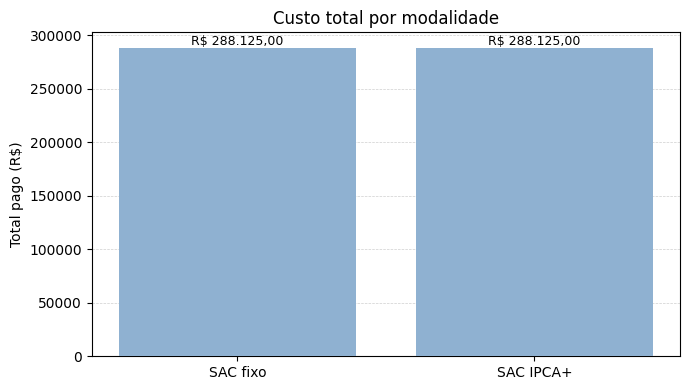

Cenário 2: Diferença


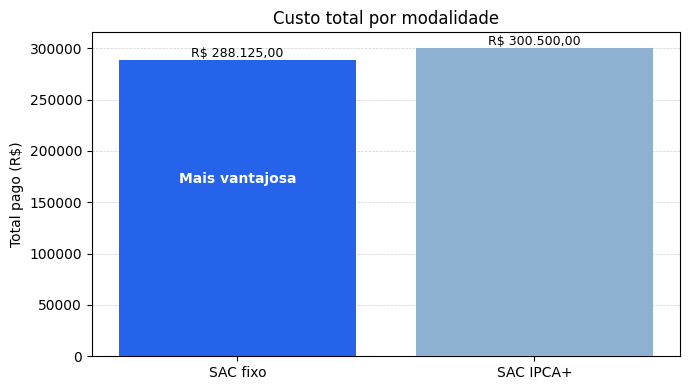

In [20]:
# Teste rápido da função plot_comparativo_totais

# Cenário 1: Empate → não deve haver destaque nem legenda
print("Cenário 1: Empate")
totais_empate = {
    "SAC fixo": 288_125.00,
    "SAC IPCA+": 288_125.00
}
plot_comparativo_totais(totais_empate)

# Cenário 2: Diferença → deve haver destaque, legenda e rótulo interno com troféu
print("Cenário 2: Diferença")
totais_diferenca = {
    "SAC fixo": 288_125.00,
    "SAC IPCA+": 300_500.00
}
plot_comparativo_totais(totais_diferenca)



# 🔎 Comparação: SAC **sem TR** × **com TR**

Nesta seção rodamos duas simulações no sistema **SAC**:
- **Sem TR**: cálculo tradicional (amortização constante + juros sobre saldo).
- **Com TR** (constante no MVP): correção do saldo antes dos juros, usando uma TR mensal definida abaixo.

Em seguida, comparamos o **total pago** e a **diferença percentual**.  
Depois, plotamos as **linhas de valor das parcelas** no mesmo gráfico para visualização direta.

In [22]:
# %% [code]
# Parâmetros base da simulação
VALOR_TOTAL = 300_000.0
ENTRADA = 50_000.0
PRAZO_ANOS = 5
TAXA_AA = 0.12        # 12% a.a. (exemplo)
TR_MENSAL = 0.002     # 0,2% a.m. (exemplo de TR constante no MVP)

# Imports do projeto
from domain.financiamento import Financiamento
from domain.simulador_sac import SimuladorSAC

# Criar dois financiamentos idênticos (objetos distintos evitam interferência de estado)
fin_sem_tr = Financiamento(
    valor_total=VALOR_TOTAL,
    entrada=ENTRADA,
    prazo_anos=PRAZO_ANOS,
    sistema="SAC",
    taxa_juros_anual=TAXA_AA,
)
fin_com_tr = Financiamento(
    valor_total=VALOR_TOTAL,
    entrada=ENTRADA,
    prazo_anos=PRAZO_ANOS,
    sistema="SAC",
    taxa_juros_anual=TAXA_AA,
)

# Instanciar simuladores
sim_sem_tr = SimuladorSAC(fin_sem_tr, TAXA_AA)
sim_com_tr = SimuladorSAC(fin_com_tr, TAXA_AA)

# Rodar simulações (SAC sem TR vs com TR)
res_sem_tr = sim_sem_tr.simular(usar_tr=False)
res_com_tr = sim_com_tr.simular(usar_tr=True, tr_mensal=TR_MENSAL)

# Asserts mínimos (sanidade)
assert len(res_sem_tr.parcelas) == len(res_com_tr.parcelas)
assert res_sem_tr.total_pago > 0 and res_com_tr.total_pago > 0

# Comparação dos totais
diff_abs = res_com_tr.total_pago - res_sem_tr.total_pago
diff_pct = (diff_abs / res_sem_tr.total_pago) * 100.0

print(f"Total pago (SAC sem TR): R$ {res_sem_tr.total_pago:,.2f}")
print(f"Total pago (SAC com TR): R$ {res_com_tr.total_pago:,.2f}")
print(f"Diferença absoluta:      R$ {diff_abs:,.2f}")
print(f"Diferença percentual:     {diff_pct:.2f}%")


Total pago (SAC sem TR): R$ 322,352.05
Total pago (SAC com TR): R$ 344,959.11
Diferença absoluta:      R$ 22,607.06
Diferença percentual:     7.01%



## 📈 Comparação SAC sem TR × SAC com TR (última parcela com TR isolada como ponto)
 
O último valor do SAC+TR é mostrado como ponto isolado no gráfico e explicado no terminal.

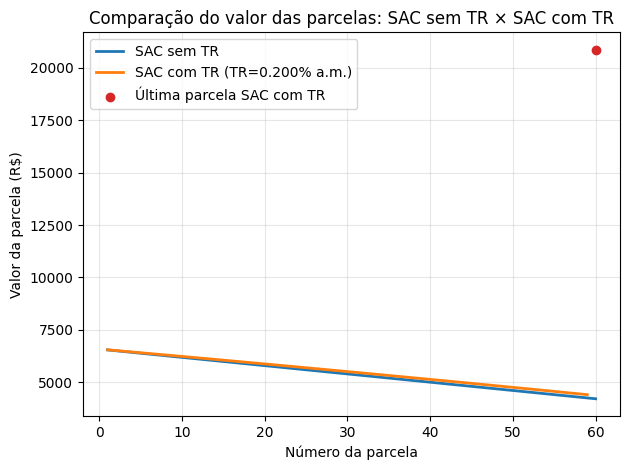

Total pago (SAC sem TR): R$ 322,352.05
Total pago (SAC com TR): R$ 344,959.11
Diferença absoluta:      R$ 22,607.06
Diferença percentual:     7.01%

ℹ️ A última parcela do SAC com TR aparece como ponto isolado porque é a parcela de quitação.
   Ela inclui a amortização final + correção acumulada pela TR, resultando em valor maior.


In [25]:
from domain.financiamento import Financiamento
from domain.simulador_sac import SimuladorSAC
import matplotlib.pyplot as plt

# ---------------- Parâmetros ----------------
VALOR_TOTAL = 300_000.0
ENTRADA = 50_000.0
PRAZO_ANOS = 5
TAXA_AA = 0.12
TR_MENSAL = 0.002   # 0,2% a.m.

# -------------- Simulações -----------------
fin_sem_tr = Financiamento(VALOR_TOTAL, ENTRADA, PRAZO_ANOS, "SAC", TAXA_AA)
fin_com_tr = Financiamento(VALOR_TOTAL, ENTRADA, PRAZO_ANOS, "SAC", TAXA_AA)

sim_sem_tr = SimuladorSAC(fin_sem_tr, TAXA_AA)
sim_com_tr = SimuladorSAC(fin_com_tr, TAXA_AA)

res_sem_tr = sim_sem_tr.simular(usar_tr=False)
res_com_tr = sim_com_tr.simular(usar_tr=True, tr_mensal=TR_MENSAL)

# -------------- Séries para gráfico --------------
y_sem = [p.valor_total for p in res_sem_tr.parcelas]
y_com = [p.valor_total for p in res_com_tr.parcelas]

x = list(range(1, len(y_sem) + 1))
x_tr_sem_ultima = x[:-1]
y_tr_sem_ultima = y_com[:-1]

# -------------- Plotagem --------------
plt.figure()
plt.plot(x, y_sem, label="SAC sem TR", color="tab:blue", linewidth=2)
plt.plot(x_tr_sem_ultima, y_tr_sem_ultima, label=f"SAC com TR (TR={TR_MENSAL:.3%} a.m.)", color="tab:orange", linewidth=2)

# Ponto isolado da última parcela com TR
plt.scatter(x[-1], y_com[-1], color="tab:red", zorder=5, label="Última parcela SAC com TR")

plt.xlabel("Número da parcela")
plt.ylabel("Valor da parcela (R$)")
plt.title("Comparação do valor das parcelas: SAC sem TR × SAC com TR")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# -------------- Comparação de totais --------------
diff_abs = res_com_tr.total_pago - res_sem_tr.total_pago
diff_pct = (diff_abs / res_sem_tr.total_pago) * 100.0

print(f"Total pago (SAC sem TR): R$ {res_sem_tr.total_pago:,.2f}")
print(f"Total pago (SAC com TR): R$ {res_com_tr.total_pago:,.2f}")
print(f"Diferença absoluta:      R$ {diff_abs:,.2f}")
print(f"Diferença percentual:     {diff_pct:.2f}%")

# -------------- Explicação do pico --------------
print("\nℹ️ A última parcela do SAC com TR aparece como ponto isolado porque é a parcela de quitação.")
print("   Ela inclui a amortização final + correção acumulada pela TR, resultando em valor maior.")
